###Pre-requisites

The program below will allow any user to run a pre-trained mask r-cnn model on the 'cherry' and 'tomato' crop images used in the Crop Classification Final project. Due to the extent of libraries needed to process this, I have included a requirements.txt file in the 'masker' library also provided for submission. 

To run this program - download, unzip, and upload all 'masker' documents including the 'masker' folder to your Google Drive. Ensure your drive is mounted in the location '/content/drive/MyDrive/masker' - or change the directory noted in the program to point to it. This program will then read all python requirements to update any dependent python libraries to run this program.

Due to the extent of resources needed to train this model, I have also uploaded the pre-trained weights of the crop classification images that were uncovered after 80 epochs of training. Should you want to train the model more, you can replace the 80 epoch limit with additional epochs, and the model will pick up from the 80th epoch to continue training. This is not recommeded unless you have a very powerful operating environment.

For more information on the steps used to create these methods or lessons learned, see 'Crop Image Classification ppt.


###Mount Google Drive

In [17]:
import os
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
os.chdir('/content/drive/MyDrive/masker')

!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Import required packages for app to run

In [19]:
import mrcnn
import mrcnn.config
import mrcnn.model
import json
import numpy as np
import skimage
import datetime
import IPython.display
import warnings
import re
import tensorflow as tf

warnings.simplefilter("ignore", UserWarning) # Ignore annoying memory warnings
warnings.simplefilter("ignore", Warning)

### Load required helpers & modules 

In [20]:
# Helper modules
from os.path import exists

# Load modules for mrcnn
from mrcnn.config import Config
from mrcnn import utils
from mrcnn import visualize
import mrcnn.model as modellib

### Define global variables and necessary paths

In [21]:
# Globals
ROOT_DIR = "."
DEFAULT_LOGS_DIR = "logs"

# COCO Defaults
COCO_MODEL_PATH = os.path.relpath("./assets/mask_rcnn_coco.h5")
# COCO_CLASS_NAMES = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
#                'bus', 'train', 'truck', 'boat', 'traffic light',
#                'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
#                'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
#                'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
#                'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
#                'kite', 'baseball bat', 'baseball glove', 'skateboard',
#                'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
#                'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
#                'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
#                'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
#                'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
#                'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
#                'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
#                'teddy bear', 'hair drier', 'toothbrush']

CLASS_NAMES = ['BG', 'cherry', 'tomato'] #BG is always the first class

### Create necessary classes
#### Tensorflow Custom Configuration & Custom Dataset Parsing classes necessary to achieve desired results

In [22]:
# Tensorflow Config Class
class CustomConfig(Config):    
    """Configuration for training on the custom  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "object"
    IMAGES_PER_GPU = 3
    NUM_THREADS = 4
    NUM_CLASSES = 1 + 2
    STEPS_PER_EPOCH = 20
    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9
    
class InferenceConfig(Config):
    """Configuration for training on the custom  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "object"
    IMAGES_PER_GPU = 1
    NUM_THREADS = 4
    NUM_CLASSES = 1 + 2
    STEPS_PER_EPOCH = 20
    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9

In [23]:
# Dataset Definition Class
class CustomDataset(utils.Dataset):

    def load_custom(self, dataset_dir, subset):
        self.add_class("object", 1, "cherry")
        self.add_class("object", 2, "tomato")

        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)        
        # We mostly care about the x and y coordinates of each region
        annotations1 = json.load(open(dataset_dir + "/" +  subset + '_annotations.json'))
        
        # print(annotations1)
        annotations = list(annotations1.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if 'regions' in a]
        
        # Add images
        for a in annotations:        
            polygons = [r['shape_attributes'] for r in a['regions']] 
            objects = [s['region_attributes'] for s in a['regions']]  

            # key = tuple(name_dict)
            class_ids = [1 if n['Crop'] == "cherry" else 2 for n in objects]     
     
            image_path = os.path.join(dataset_dir , a['filename'])
            print("Loading image: " + image_path)
            if (exists(image_path)):
                image = skimage.io.imread(image_path)
                height, width = image.shape[:2]

                self.add_image(
                    "object",  ## for a single class just add the name here
                    image_id=a['filename'],  # use file name as a unique image id
                    path=image_path,
                    width=width, height=height,
                    polygons=polygons,
                    class_ids=class_ids
                    )
                    
    def load_mask(self, image_id):
        """Generate instance masks for an image.
        Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        
        class_ids = info['class_ids']
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])], dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            if p['name'] == 'polygon':
                rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
                mask[rr, cc, i] = 1          
            elif p['name'] == 'circle':
                rr, cc = skimage.draw.circle(p["cy"], p["cx"], p["r"])
                mask[rr, cc, i] = 1
            else:
                rr, cc = skimage.draw.ellipse(p['cy'], p['cx'], p['ry'], p['rx'], rotation=np.deg2rad(p['theta']))
                mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        # Map class names to class IDs.
        class_ids = np.array(class_ids, dtype=np.int32)        
        return mask, class_ids

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "object":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

### Define our `train` method, which loads our custom datasets and executes the mrcnn train method

In [24]:
def train(model):
    """Train the model."""
    # Training dataset.
    dataset_train = CustomDataset()
    dataset_train.load_custom("./assets/", "train")
    dataset_train.prepare()

    # Validation dataset
    dataset_val = CustomDataset()
    dataset_val.load_custom("./assets/", "val")
    dataset_val.prepare()

    # *** This training schedule is an example. Update to your needs ***
    # Since we're using a very small dataset, and starting from
    # COCO trained weights, we don't need to train too long. Also,
    # no need to train all layers, just the heads should do it.
    print("Training...")
    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=80,                
                layers='heads')

### Define our visualization methods and command execution functions

In [25]:
def color_splash(image, mask):
    """
    Apply color splash effect.
    image: RGB image [height, width, 3]
    mask: instance segmentation mask [height, width, instance count]
    Returns result image.
    """
    # Make a grayscale copy of the image. The grayscale copy still
    # has 3 RGB channels, though.
    gray = skimage.color.gray2rgb(skimage.color.rgb2gray(image)) * 255
    # We're treating all instances as one, so collapse the mask into one layer
    mask = (np.sum(mask, -1, keepdims=True) >= 1)
    # Copy color pixels from the original color image where mask is set
    if mask.shape[0] > 0:
        splash = np.where(mask, image, gray).astype(np.uint8)
    else:
        splash = gray
    return splash


def detect_and_color_splash(model, image_path=None):
    """
    Detectsand generatesa color splash effect against a given image
    Saves an image in greyscale with detected areas colored in.
    """
    if image_path:
        # Run model detection and generate the color splash effect
        print("Running on {}".format(image_path))
        # Read image
        image = skimage.io.imread(imange_path)
        # Detect objects
        r = model.detect([image], verbose=1)[0]
        # Color splash
        splash = color_splash(image, r['masks'])
        # Save output
        file_name = "splash_{:%Y%m%dT%H%M%S}.png".format(datetime.datetime.now())
        skimage.io.imsave(file_name, splash)
   
    print("Saved to ", file_name)

def visualize_detection(model, image_path):
    """
    Detect and generates identification segment against a given image
    Displays the given image with detected segments highlighted by bounding boxes
    """
    if image_path:
        print("Running on {}".format(image_path))
        # Read image
        image = skimage.io.imread(image_path)
        # Detect objects
        r = model.detect([image], verbose=1)[0]        
        visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], CLASS_NAMES, r['scores'])

def plot_detection(model):
    """
    Plots detection results of the provided model
    """    
    # Read image
    # Detect objects
    tables = visualize.display_weight_stats(model)

### Train the model and use the model to validate against a validation image

In [26]:
config = CustomConfig()
inference_config = InferenceConfig() 

model = modellib.MaskRCNN(mode="training", config=config, model_dir=DEFAULT_LOGS_DIR)

# Load the previously generated weights or COCO weights if first pass
try:
    weights_path = model.find_last()
except:
    weights_path = COCO_MODEL_PATH

print("Loading weights ", weights_path)

if COCO_MODEL_PATH == weights_path:
    model.load_weights(COCO_MODEL_PATH, by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc","mrcnn_bbox", "mrcnn_mask"])
else:
    model.load_weights(weights_path, by_name=True)
    
    
train(model)
print("Finished training model. Displaying detection stats.")

Loading weights  logs/object20221121T1917/mask_rcnn_object_0080.h5
Re-starting from epoch 80
Loading image: ./assets/train/cherry1.jpeg
Loading image: ./assets/train/cherry2.jpeg
Loading image: ./assets/train/cherry3.jpeg
Loading image: ./assets/train/cherry4.jpeg
Loading image: ./assets/train/cherry5.jpeg
Loading image: ./assets/train/cherry6.jpeg
Loading image: ./assets/train/cherry7.jpeg
Loading image: ./assets/train/cherry8.jpeg
Loading image: ./assets/train/cherry9.jpeg
Loading image: ./assets/train/cherry10.jpeg
Loading image: ./assets/train/cherry11.jpeg
Loading image: ./assets/train/cherry12.jpeg
Loading image: ./assets/train/cherry13.jpeg
Loading image: ./assets/train/cherry14.jpeg
Loading image: ./assets/train/cherry15.jpg
Loading image: ./assets/train/cherry16.jpg
Loading image: ./assets/train/cherry17.jpg
Loading image: ./assets/train/cherry18.jpg
Loading image: ./assets/train/cherry19.jpg
Loading image: ./assets/train/cherry20.jpg
Loading image: ./assets/train/cherry21.jpg

Finished training model. Displaying detection stats.


In [27]:
model = modellib.MaskRCNN(mode="inference", config=inference_config, model_dir=DEFAULT_LOGS_DIR)

if model.find_last() is not None:
    model.load_weights(model.find_last(), by_name=True)



Instructions for updating:
Use `tf.cast` instead.


Re-starting from epoch 80


Running on ./assets/val/cherry25.jpg
Processing 1 images
image                    shape: (183, 275, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


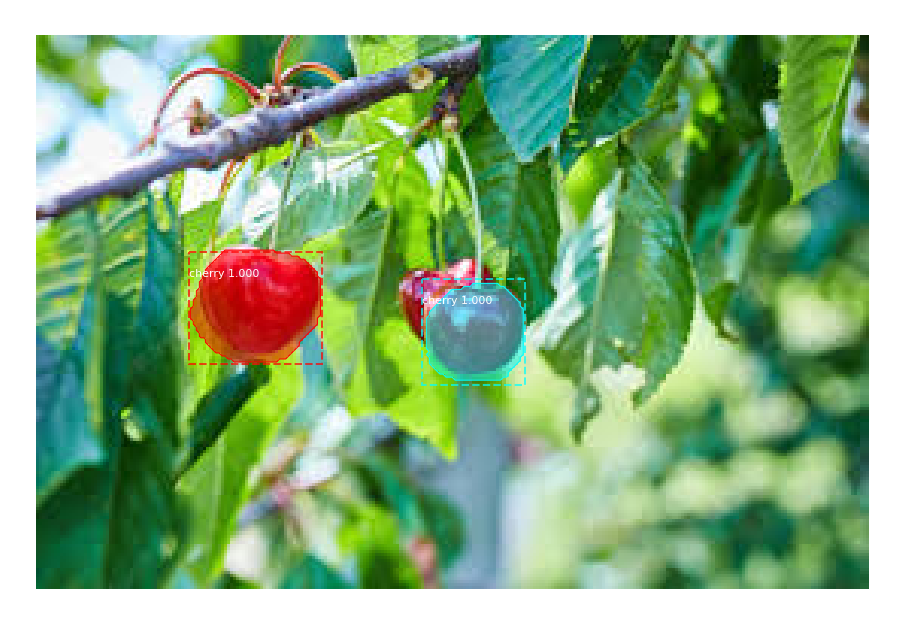

In [28]:
visualize_detection(model, image_path="./assets/val/cherry25.jpg")

Running on ./assets/val/tomato21.jpeg
Processing 1 images
image                    shape: (205, 246, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  136.20000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


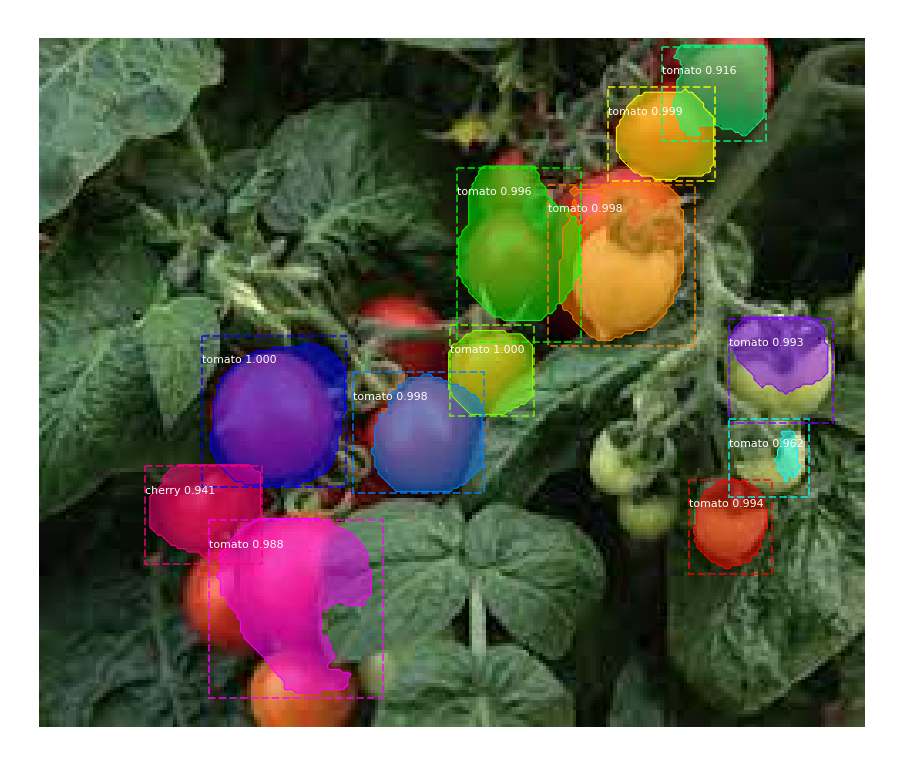

In [29]:
visualize_detection(model, image_path="./assets/val/tomato21.jpeg")

In [30]:
validation_dir = os.scandir('./assets/val')
validation_images = []

for f in validation_dir:
    #print(re.findall(r'jpg', f.name))
    if len(re.findall(r'jpeg|jpg', f.name)) > 0:
        validation_images.append(f.name)

validated_images = []
for img in validation_images:
    image = skimage.io.imread('./assets/val/'+img)
    r = model.detect(images=[image])
    #image = skimage.io.imread('./assets/val/'+f_name)    
    #visualize.display_instances(image, img[0]['rois'], img[0]['masks'], img[0]['class_ids'], CLASS_NAMES, img[0]['scores'])    
    validated_images.append(r)
    
counter = 0
correctly_classified = 0
for img in validated_images:
    f_name = validation_images[counter]
    counter += 1    
    found = { 'cherries': 0, 'tomatos': 0 }    
    for i in img[0]['class_ids']:
        if i == 1:
            found['cherries'] += 1
        else:
            found['tomatos'] += 1
    image_max = 'cherry' if found['cherries'] > found['tomatos'] else 'tomato'
    #image = skimage.io.imread('./assets/val/'+f_name)
    #visualize.display_instances(image, img[0]['rois'], img[0]['masks'], img[0]['class_ids'], CLASS_NAMES, img[0]['scores'])
    
    if (re.match(image_max, f_name)): correctly_classified += 1
        
    print("Found " + str(found['cherries']) + " cherries and " + str(found['tomatos']) + " tomatos in " + f_name+". Image classified as "+image_max)


Found 1 cherries and 11 tomatos in tomato21.jpeg. Image classified as tomato
Found 2 cherries and 0 tomatos in cherry27.jpg. Image classified as cherry
Found 0 cherries and 0 tomatos in cherry26.jpg. Image classified as tomato
Found 6 cherries and 1 tomatos in cherry32.jpg. Image classified as cherry
Found 0 cherries and 6 tomatos in tomato23.jpeg. Image classified as tomato
Found 7 cherries and 0 tomatos in cherry29.jpg. Image classified as cherry
Found 2 cherries and 0 tomatos in cherry25.jpg. Image classified as cherry
Found 2 cherries and 0 tomatos in cherry30.jpg. Image classified as cherry
Found 0 cherries and 15 tomatos in tomato25.jpeg. Image classified as tomato
Found 0 cherries and 6 tomatos in tomato24.jpeg. Image classified as tomato
Found 3 cherries and 0 tomatos in cherry28.jpg. Image classified as cherry
Found 3 cherries and 1 tomatos in cherry31.jpg. Image classified as cherry
Found 0 cherries and 81 tomatos in tomato22.jpeg. Image classified as tomato
Found 6 cherries 

In [31]:
print("Detected image classification with accuracy of " + "{0:.0%}".format(correctly_classified / len(validation_images)))

Detected image classification with accuracy of 86%
